# CRAFTY
Progetto esame laboratorio di web scraping appello 18 Luglio 2023 di Michele Suffredini (Mat: 619611)

### Librerie Importate



In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import requests as rq
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

### Lettura Data Sets
Utilizzo una funzione di pandas per leggere i file .csv e transformarli in dataframes; in particolare il dataset transazioni che contiene una colonna timestamp viene trasformata in formato data per praticità e per lo stesso motivo anche nel dataframe mapping che contiene solo 2 colonne utilizzo la colonna addressId come indice.

__ATTENZIONE!! Se si prova ad eseguire questo progetto assicurarsi che all'interno della cartella di questo notebook sia presente una cartella di nome "Blockhain_Datasets" con tutti i 4 file .csv al suo interno__

In [2]:
transazioni = pd.read_csv('./Blockhain_Datasets/transactions.csv', names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'])
transazioni['timestamp'] = pd.to_datetime(transazioni['timestamp'], unit='s')

inputs = pd.read_csv('./Blockhain_Datasets/inputs.csv', names=['txId', 'prevTxId', 'prevTxPos'])

outputs = pd.read_csv('./Blockhain_Datasets/outputs.csv', names=['txId', 'position', 'addressId', 'amount', 'scriptType'])

mapping = pd.read_csv('./Blockhain_Datasets/mapping.csv', names=['hash', 'addressId'], index_col='addressId')

# [1.1] Distribuzione del numero di transazioni per blocco per tutto il periodo a disposizione nel dataset
Per questa analisi basta ottenere i gruppi delle transazioni che hanno lo stesso blockId tramite la groupby e successivamente eseguire la size in modo da ottenere il numero di transazioni per ogni blocco.
Essendo il primo grafo ed essendo semplice ho deciso solo per questo punto di stamparlo con la funzione plot di pandas.

<AxesSubplot: title={'center': 'Distribuzione delle transazioni per blocco'}, xlabel='ID del blocco', ylabel='Numero di transazioni'>

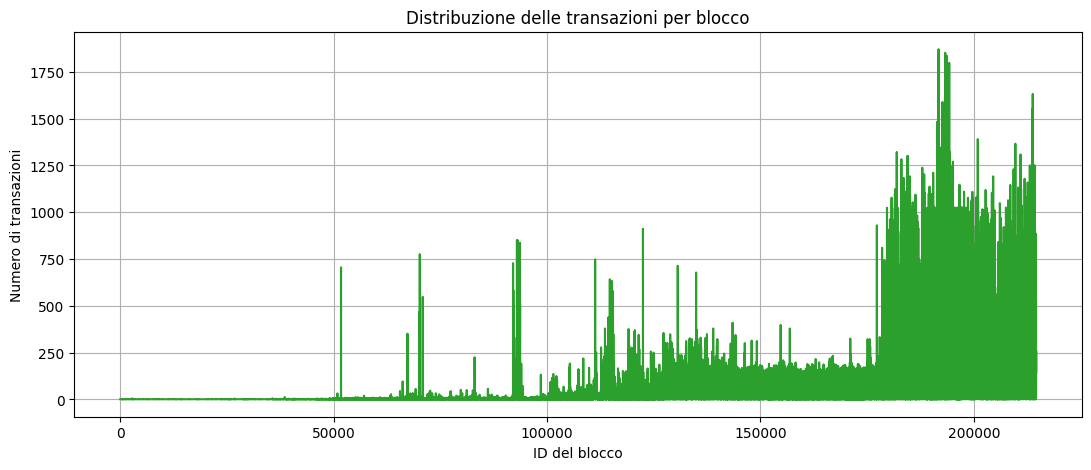

In [3]:
dist_per_blocco = transazioni.groupby('blockId').size()
dist_per_blocco.plot( grid=True,
                      figsize=(13, 5),
                      color="tab:green" ,
                      title='Distribuzione delle transazioni per blocco',
                      ylabel='Numero di transazioni',
                      xlabel='ID del blocco')

# [1.2] Evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due mesi con creazione di un grafico che riporti il numero di transazioni medie nel periodo considerato
Inizio creando delle liste che serviranno per accumulare i dati di tutte le coppie dei mesi corrispondenti; poi creo una lista che ha come elementi delle date che hanno una distanza temporale tra loro esattemente di 2 mesi tramite la funzione date_range di pandas.

*Le date all'interno non corrispondono esattamente alle date di inizio a fine delle tranzsazioni del dataset ma servono per evitare di saltare dei mesi in quanto nel parametro freq uso 2MS che corrisponde a 2 mesi partendo dall'inizio del mese quindi passando 3/1/2009 come start nel data_range la funzione partizionerebbe le date dal 1/2/2009 perdendo quindi tutto gennaio e sfalzando le coppie di 1 mese, la stessa cosa vale per 
1/1/2013 serve per non perdere il mese di dicembre del 2012.*

All'interno di un for scorro tutte le date nella lista e grazie alla funzione between seleziono soltanto le transazioni avvenite tra la data selezionata dal for e la successiva delle quali poi effettuo come nel punto [1.1] groupby del blocco poi size e in più la media per poi aggiungere il risultato alla lista delle medie della corrispettiva coppia di mesi.

Per la rappresentazioni dei risultati ho scelto un grafico a istogrammi partizionato per coppie di mesi e per anni

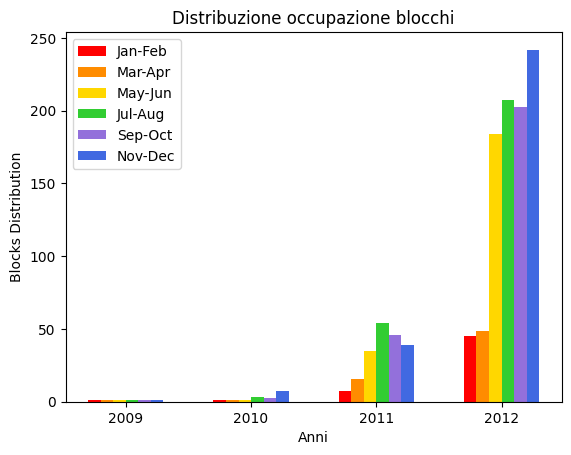

In [4]:
gen_feb = list()
mar_apr = list()
mag_giu = list()
lug_ago = list()
set_ott = list()
nov_dic = list()

lista_coppie_mesi = pd.date_range(start = '2009-01-01', end = '2013-01-01', freq = '2MS')
for i in range(len(lista_coppie_mesi)-1):
    tx_due_mesi = transazioni[transazioni['timestamp'].between(lista_coppie_mesi[i], lista_coppie_mesi[i+1])]
    media_dist_due_mesi = tx_due_mesi.groupby('blockId').size().mean()

    if(lista_coppie_mesi[i].month_name() == "January" ):
        gen_feb.append(media_dist_due_mesi)
    if(lista_coppie_mesi[i].month_name() == "March"):
        mar_apr.append(media_dist_due_mesi)
    if(lista_coppie_mesi[i].month_name() == "May"):
        mag_giu.append(media_dist_due_mesi)
    if(lista_coppie_mesi[i].month_name() == "July"):
        lug_ago.append(media_dist_due_mesi)
    if(lista_coppie_mesi[i].month_name() == "September"):
        set_ott.append(media_dist_due_mesi)
    if(lista_coppie_mesi[i].month_name() == "November"):
        nov_dic.append(media_dist_due_mesi)

x = np.array([100, 200, 300, 400]) #posizioni barre dei 4 anni
width = 10 #larghezza barre

plt.figsize=(10, 5)
plt.title('Distribuzione occupazione blocchi')
            #array posizioni, array contenuti barre, larghezza, colore  --- mappa una posizione per un contenuto barra
bar1 = plt.bar(x - 2 * width, gen_feb, width, color = 'red')
bar2 = plt.bar(x - width, mar_apr, width, color = 'darkorange')
bar3 = plt.bar(x, mag_giu, width, color = 'gold')
bar4 = plt.bar(x + width, lug_ago, width, color = 'limegreen')
bar5 = plt.bar(x + 2 * width, set_ott, width, color = 'mediumpurple')
bar6 = plt.bar(x + 3 * width, nov_dic, width, color = 'royalblue')
plt.xticks(x + width/2, [2009, 2010, 2011, 2012])
plt.xlabel("Anni")
plt.ylabel("Blocks Distribution")
plt.legend(['Jan-Feb', 'Mar-Apr', 'May-Jun', 'Jul-Aug', 'Sep-Oct', 'Nov-Dec'])
plt.show()

# [1.3] Ammontare totale degli UTXO al momento dell’ultima transazione registrata nella blockchain considerata
Questa analisi si basa solamente su una merge tra input e output con la quale effetuo una innerjoin tra le colonne corrette in modo da ottenere un dataframe degli outputs che sono diventati poi inputs e quindi sono stati spesi.
Con una semplice differenza tra outputs totali e outputs spesi toviamo gli outputs non spesi.
Ho scelto di mostrare 2 grafici il primo risalta il numero di outputs non spesi su quelli spesi mentre il secondo mostra il valore di satoshi degli outputs non ancora spesi su quelli invece spesi;
si nota subito una differenza che i satoshi sono stati praticamente tutti spesi nonostante il 13% degli outputs non sia stato rispeso, quindì quel 13% contiene pochissimi satoshi rispetto al totale.

Utxo : 3194301
Utxo satoshi : 859303372614879


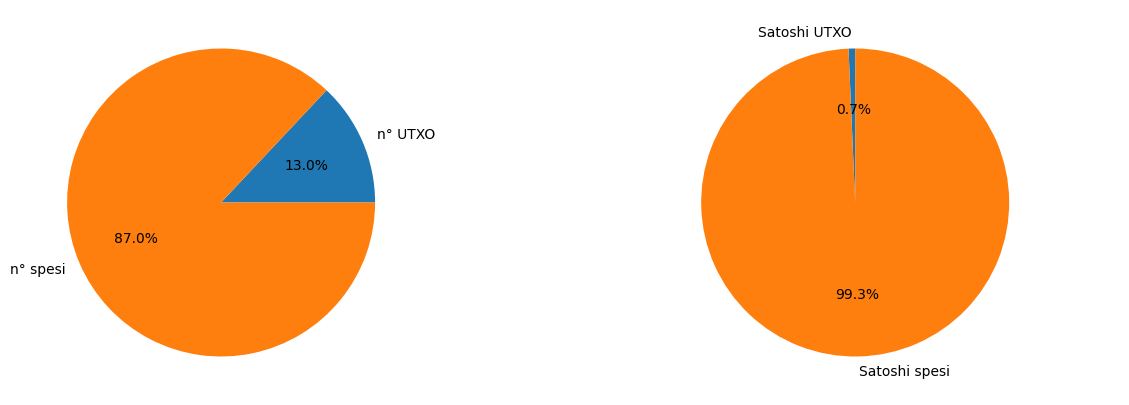

In [5]:
#UTXO output di una trasazione che non è stato ancora speso
# 1 Bitcoin = 100.000.000 Satoshi

output_spesi = inputs.merge(outputs, how="inner" ,left_on=['prevTxId', 'prevTxPos'], right_on=['txId', 'position'])
#prevTxId e txId rappresentano la stessa transazione ma vista da output e input
#prevTxPos e position rappresentano la stessa posizione nella transazione ma vista da output e input

#Numero output non ancora spesi (UTXO) 
numero_ouput = len(outputs)
numero_output_spesi = len(output_spesi)
numero_utxo = numero_ouput - numero_output_spesi
print("Utxo :",numero_utxo)

#Satoshi non ancora spesi (UTXO)
output_totale_satoshi = outputs['amount'].sum()
output_satoshi_spesi = output_spesi['amount'].sum()
utxo_satoshi = output_totale_satoshi - output_satoshi_spesi
print("Utxo satoshi :",utxo_satoshi)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.axis('equal')
ax[0].pie([numero_utxo, numero_output_spesi], labels=['n° UTXO', 'n° spesi'], autopct='%1.1f%%', colors=['tab:blue', 'tab:orange'])
ax[1].pie([utxo_satoshi, output_satoshi_spesi], labels=['Satoshi UTXO', 'Satoshi spesi'], autopct='%1.1f%%', startangle=90, colors=['tab:blue', 'tab:orange'])
plt.show()

# [1.4] Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un valore in output e quella che lo consuma, per gli output spesi nel periodo considerato.
Effettuo 2 merge outputs-transazioni e inputs-transazioni per creare dataframe che associano agli outputs la data della loro generazione e associano agli inputs (nonche ex outputs) la data della loro spesa (eseguo rename dei timestamp per evitare problemi con merge successivi e per chiarire meglio).
Eseguo un altra merge sui 2 nuovi dataframe per Id della transazione con id transazione precedente che genera l'attuale input in modo da avere per ogni riga tutti gli output con 2 colonne, una che indica la data di creazione e una che inidica la data della spesa.
Tramite questo dataframe genero una nuova colonna per ogni riga che ha come valori la differenza in giorni tra la data di creazione e la data di spesa e rimuovo le transazioni con differenza negativa che possono essere causate da inserimenti asincroni dei miner all'interno della blockchain.
Facendo una groupby sulla colonna che indica il tempo tra creazione e spesa raggruppiamo gli outputs che hanno lo stesso tempo di generazione e consumo e poi effettuo una size per usarlo nel grafico. 

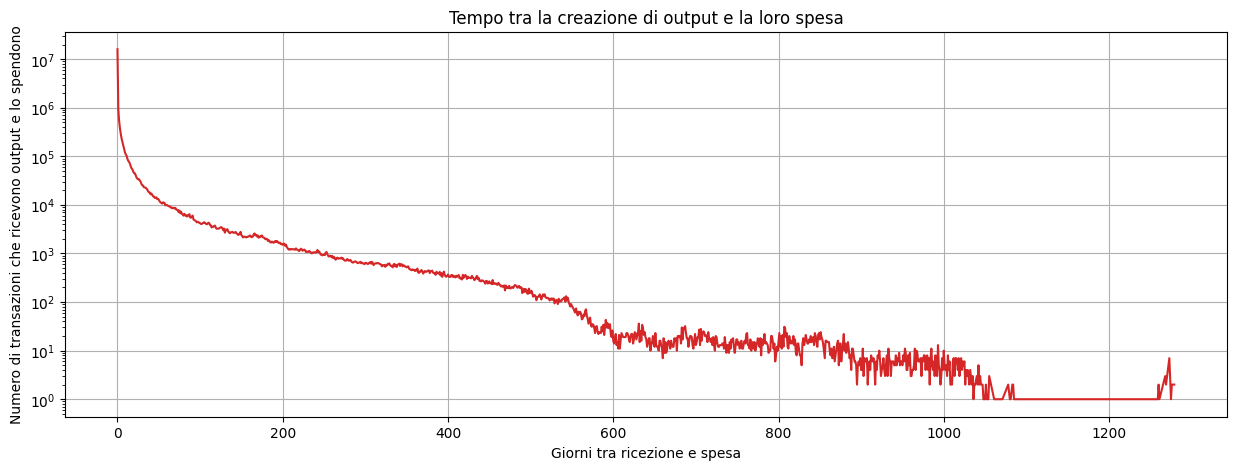

In [6]:
tx_creazione = outputs.merge(transazioni, how = "inner",on = "txId").rename(columns = {'timestamp': 'Creation date'})[['txId', 'position', 'Creation date']] 
tx_spesa = inputs.merge(transazioni, how = 'inner').rename(columns = {'timestamp': 'Spent date'})[['txId', 'prevTxId', 'prevTxPos', 'Spent date']] 

differenza_tempo = tx_spesa.merge(tx_creazione, how = 'inner', left_on = ['prevTxId', 'prevTxPos'], right_on = ['txId', 'position']) 
differenza_tempo['Days of difference'] = (differenza_tempo['Spent date'] - differenza_tempo['Creation date']).dt.days 

# Rimuovo transazioni con differenza di giorni negativa
differenza_tempo = differenza_tempo.loc[differenza_tempo['Days of difference'] >= 0] 

gruppi_giorni_transazioni = differenza_tempo.groupby('Days of difference')['prevTxId'].size()

plt.figure(figsize = (15, 5))
plt.title('Tempo tra la creazione di output e la loro spesa')
plt.xlabel('Giorni tra ricezione e spesa')
plt.ylabel('Numero di transazioni che ricevono output e lo spendono')
plt.grid()
plt.plot(gruppi_giorni_transazioni, color = 'tab:red') 
plt.yscale(value = 'log')
plt.show()

# [1.5] Analisi transazioni Coinbase sul totale e nei 4 anni del dataset fornito. Calcolo andamento quantità di Satoshi generati da transazioni coinbase nel 2011

Per queste analisi serve filtrare dal dataframe delle transazioni solo quelle che hanno nella colonna coinbase il numero 1, poi prendo il numero di righe dei 2 dataframe e stampo il grafico a torta.
Il secondo grafico (nello stesso stile del punto 1.2) risalta il numero di transazioni coinbase divise per ciascun anno nel quale possiamo notare che il 2011 è l'anno in cui sono state fatte più transazioni coinbase (da qui la scelta di questo anno per l'ultima analisi).
Effettuo la merge tra le transazioni coinbase e gli outputs per avere accesso al quantitativo degli output derivato dalle transazioni coinbase che ricordo non possiedono un input; filtro le transazioni solo per l'anno 2011 e stampo il grafico di prendendo come assi le colonne delle valore di satoshi generati e la data nella quale sono generati (la scelta di un singolo anno è data dal fatto che il grafico è molto compatto in quanto tanti dati e quindi poco comprensibile con così tante transazioni).
Infine stampo il numero di Satoshi totali generati nel 2011 calcolati con la funzione sum()

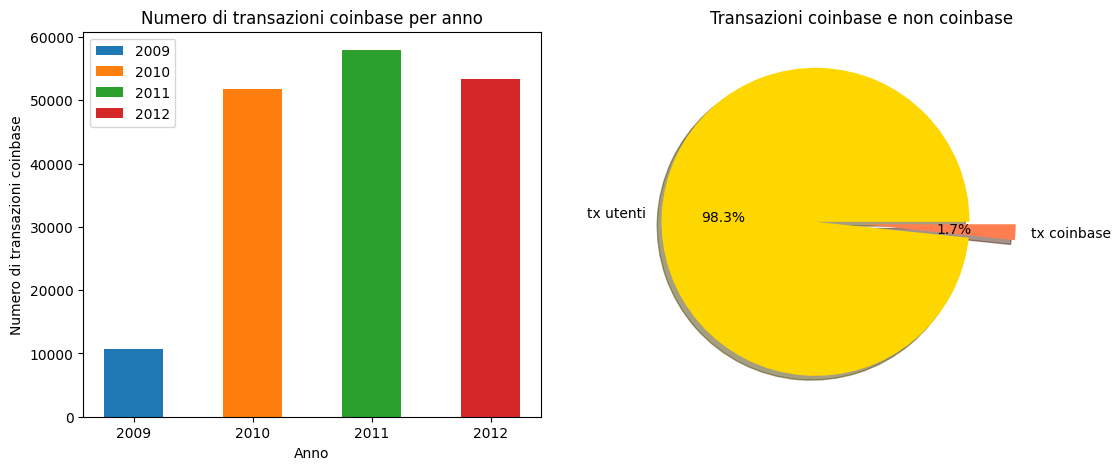

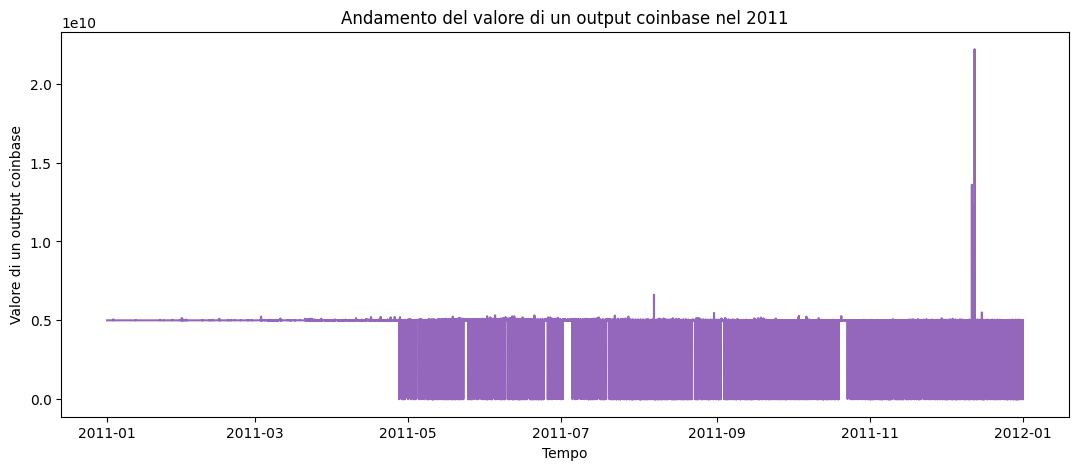

Satoshi generati nel 2011:  290020009446106  Sats   =    2900200.09446106  BTC


In [7]:
numero_tot_transazioni = len(transazioni) #10532115 
transazioni_coinbase = transazioni[transazioni.isCoinbase == 1]
numero_transazioni_coinbase = len(transazioni_coinbase) # 173849

lista_anni = pd.date_range(start = '2009-01-01', end = '2013-01-01', freq = 'YS') #Creo lista con gli anni

y_2009 = list()
y_2010 = list()
y_2011 = list()
y_2012 = list()

for i in range(0, len(lista_anni) - 1):
    coinbase_per_anno = transazioni_coinbase[(transazioni_coinbase.timestamp >= lista_anni[i]) & (transazioni_coinbase.timestamp < lista_anni[i + 1])]
    
    if lista_anni[i].year == 2009:
        y_2009=coinbase_per_anno
    if lista_anni[i].year == 2010:
        y_2010=coinbase_per_anno
    if lista_anni[i].year == 2011:
        y_2011=coinbase_per_anno
    if lista_anni[i].year == 2012:
        y_2012=coinbase_per_anno

output_tx_coinbase = transazioni_coinbase.merge(outputs, how = 'inner', on = 'txId')[['txId', 'amount', 'timestamp']] 
output_tx_coinbase_2011 = output_tx_coinbase[(output_tx_coinbase.timestamp >= '2011-01-01') & (output_tx_coinbase.timestamp < '2012-01-01')] # Seleziono solo transazioni 2011
satoshi_generati_2011 = output_tx_coinbase_2011['amount'].sum()

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
larghezza = 0.5
ax[0].figsize=(5, 5)
ax[0].set_title('Numero di transazioni coinbase per anno')
ax[0].set_xlabel('Anno')
ax[0].set_ylabel('Numero di transazioni coinbase')
bar1 = ax[0].bar('2009', len(y_2009), larghezza, color = 'tab:blue')
bar2 = ax[0].bar('2010', len(y_2010), larghezza, color = 'tab:orange')
bar3 = ax[0].bar('2011', len(y_2011), larghezza, color = 'tab:green')
bar4 = ax[0].bar('2012', len(y_2012), larghezza, color = 'tab:red')
ax[0].legend((bar1, bar2, bar3, bar4), ('2009', '2010', '2011', '2012'))

ax[1].set_title('Transazioni coinbase e non coinbase')
ax[1] = plt.pie([numero_tot_transazioni-numero_transazioni_coinbase,numero_transazioni_coinbase], labels=['tx utenti','tx coinbase'], autopct='%1.1f%%',explode=(0.3,0), colors=['gold', 'coral'], shadow=True)

plt.figure(figsize = (13, 5))
plt.title('Andamento del valore di un output coinbase nel 2011')
plt.xlabel('Tempo')
plt.ylabel('Valore di un output coinbase')
plt.plot(output_tx_coinbase_2011['timestamp'], output_tx_coinbase_2011['amount'], color = 'tab:purple')
plt.show()

print('Satoshi generati nel 2011: ', satoshi_generati_2011, ' Sats   =   ', satoshi_generati_2011 / 100000000, ' BTC')


# [2] Clusterizzazione degli indirizzi Bitcoin
Per ogni ID di transazioni genero un gruppo che contiene tutti gli input usati in essa così da rimuovere gli id delle transazioni effettuate con 0 (coinbase) o 1 input che per il nostro fine sono inutili, tramite l'utilizzo della groupby() e di isin() che restituisce True o False se un elemento è presente in una colonna (la uso per filtrare) 
Dopo aver trovato gli inputs che servono tramite una merge andiamo a prendere gli outputs che sono diventati i nostri inputs appena trovati in modo da avere accesso all'indirizzi ai quali essi sono stati inviati.
Infine prima di procedere con l'agloritmto di Clustering creo una lista che ha come elementi gli indirizzi delle transazioni con a loro associati una lista di indirizzi pubblici associati agli input usati per quella transazioni.

Con i dati ottenuti eseguo l'algoritmo di clustering:
- Inizzializzo un grafico orientato tramite la funzione DiGraph() di networkx e aggiungo tutti gli addressId come nodi 
- Scorro tramite un for tutti le transazioni, della lista precendetemente creata, e per ognuna grazie ad un altro for scorro la lista di indirizzi associati agli input e aggiungo degli archi tra questi indirizzi all'interno del grafo senza ripetere archi quindi verificando che già non esistano e senza creare selfloop
- Tramite la funzione weakly_connected_components(graph) di networkx calcolo le componenti connesse e le inserisco all'interno di una lista che avrà come elementi dei set che contengono gli indirizzi conessi

Per concludere stampo alcune informazioni statistiche sui cluster e produco un grafico che mostra la distribuzione del numero di indirizzi dentro i clusters

Tempo esecuzione: 1m 4.0s

Numero di cluster:  4800614
Cluster più grande:  259773
Cluster più piccolo:  1
Grandezza media cluster:  1.8141056539850944
Grandezza top 10 clusters:  [259773, 121464, 99645, 76923, 40969, 30916, 26615, 20136, 19894, 16977]


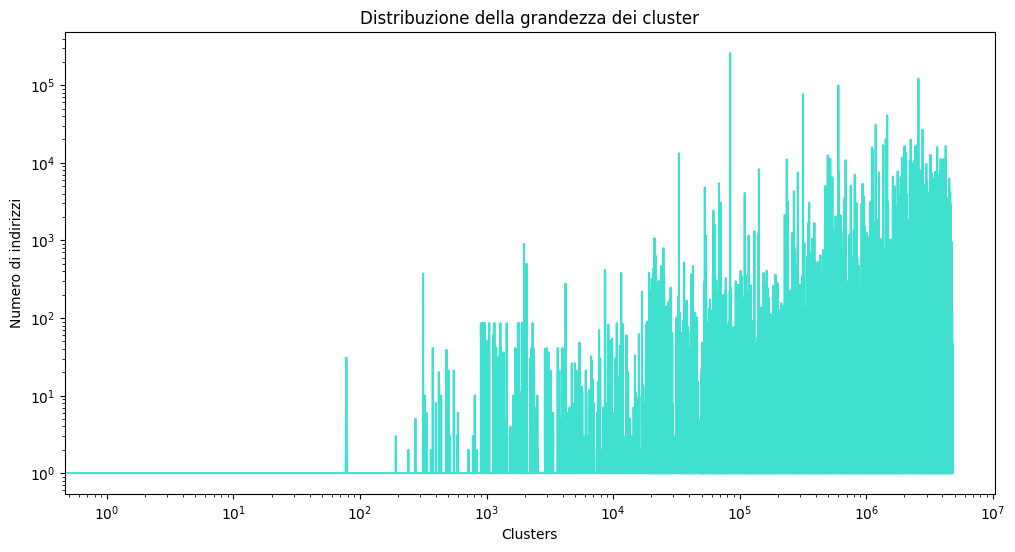

In [8]:

gruppi_input_per_tx = inputs.groupby('txId')['prevTxId'].size()  # Raggruppo input per singola transazione 
gruppi_tx_input_multipli = gruppi_input_per_tx.loc[gruppi_input_per_tx > 1] # Seleziono solo gruppi con più di un input
tx_con_input_multipli = inputs.loc[inputs['txId'].isin(gruppi_tx_input_multipli.index)].reset_index(drop=True)  # Seleziono solo transazioni con più di un input

tx_provenienza_input = tx_con_input_multipli.merge(outputs, how = 'inner', left_on=['prevTxId', 'prevTxPos'], right_on=['txId', 'position'])[['txId_x','addressId']] #data frame transazione e indirizzo pubblico di provenienza di un input 
tx_provenienza_input.rename(columns = {'txId_x': 'txId', 'addressId':'addressIdInput'}, inplace = True) # Rinomino le colonne per praticità

                                                    # (elemento per cui raggruppare) [colonne da inserire nel gruppo]
indirizzi_pubblici_per_tx = tx_provenienza_input.groupby('txId')['addressIdInput'].apply(list) # Raggruppo indirizzi pubblici per transazione

'''--------- Algoritmo Clustering----------'''

#Parte 1 - Creazione del grafo ------------------------------------------

grafo_transazioni = nx.DiGraph() # Creo un grafo orientato vuoto
grafo_transazioni.add_nodes_from(mapping.index) # Aggiungo i nodi al grafo numerati da 0 a n-1 (n = numero di indirizzi pubblici) --- mapping index array indici indirizzi 

#Parte 2 - Creazione degli archi ----------------------------------------

for indirizzi in indirizzi_pubblici_per_tx.values: #dove indiriizzi è un array di indirizzi pubblici per ogni transazione
    testa = indirizzi[0] #prendo il primo indirizzo pubblico
    for indirizzo in indirizzi[1:]: #per ogni indirizzo pubblico dentro l'array escluso il primo
        if not(grafo_transazioni.has_edge(testa,indirizzo) and (indirizzo != testa)): #se non esiste già un arco tra i due indirizzi pubblici
            grafo_transazioni.add_edge(testa,indirizzo)

#Parte 3 - Calcolo delle componenti connesse -----------------------------

componenti_connesse = nx.weakly_connected_components(grafo_transazioni) # Calcolo le componenti connesse del grafo orientato

#Parte 4 - Analisi delle componenti connesse -----------------------------

cluster = list(componenti_connesse) # metto i cluster in una lista
numero_cluster = len(cluster) # Calcolo il numero di componenti connesse
top_10_cluster = sorted(cluster, key = len, reverse = True)[:10] # Ordino le componenti connesse in ordine decrescente di dimensione e ne seleziono le prime 5
last_5_cluster = sorted(cluster, key = len)[:5] # Ordino le componenti connesse in ordine crescente di dimensione e ne seleziono le prime 5
grandezza_cluster = list(map(len, cluster)) # Calcolo la dimensione di ogni componente connessa

print("Numero di cluster: ", numero_cluster)
print("Cluster più grande: ", len(top_10_cluster[0]))
print("Cluster più piccolo: ", len(last_5_cluster[0]))
print("Grandezza media cluster: ", np.mean(grandezza_cluster))
print("Grandezza top 10 clusters: ", list(map(len, top_10_cluster)))

#Parte 5 - Plot del grafo -------------------------------------------------

plt.figure(figsize = (12, 6))
plt.title('Distribuzione della grandezza dei cluster')
plt.xlabel('Clusters')
plt.ylabel('Numero di indirizzi')
plt.plot(grandezza_cluster, color = 'turquoise')
plt.yscale(value = 'log')
plt.xscale(value = 'log')
plt.show()

# [3] Deanonimizzazione dei 10 cluster più grandi
In questo punto cerchiamo di trovare il nome del wallet associato agli indirizzi presenti in un cluster cercando gli stessi indirizzi su 2 siti che forniscono informazioni sulle transazioni e blockchain bitcoin tramite i seguenti script di web scraping.
Per effettuare lo scraping dai 2 siti ho adottato lo stesso approccio concettuale in quanto in entrambi i casi mi creo 4 funzioni che fanno le stesse cose però utilizzando 2 librerire diverse; per il primo sito Wallet Explorer ho utilizzato Beautifull Soup mentre per il secondo Bitcoin Info Charts ho utilizzato Selenium.
Come primo passaggio ho esplorato visivamente e tramite lo strumento dei browser ispeziona pagina per capirne le fattezze, come modificare le url per le richieste e dove trovare l'informazione del nome del wallet che stavo cercando; grazie a questi dati poi ho costruito le seguenti funzioni:
- converti_indirizzo_id_hash(id) che transforma l'indirizzo da Id ad Hash
- query_url(hash_idnirizzo) che produce l'url con integrata la query per l'indirizzo che stiamo cercando
- ricerca_nome_wallet(hash_indirizzo) che per il singolo indirizzo fa una richiesta get con l'url generata da query_url() e restituisce il nome del wallet se presente
- deanonimizzatore_cluster(cluster, lista) che prende tutti gli inidirizzi di un cluster e per ognuno di essi chiama la funzione ricerca_nome_wallet finche non trova il wallet o no fa un tot di tentativi fallimentari

Infine chiamo questa funzione sui primi 10 cluster per grandezza e metto i risultati all'interno di una lista

## Wallet Explorer

Note importatni:
- per fare la richiesta get bisogna aggiungere all'url "/?q=" e l'hash dell'indirizzo
- lo status code 429 indica che sono state fatte troppe richieste e che il sito ci ha bloccati
- il sito contiene l'informazione cercata nel primo tag html *h2* e al suo interno ci può essere un nome o un codice fra parentesi quadre
- le sleep tra transazioni e cluster sono inserite apposta per evitare alcun tipo di ban
- di ciascun cluster testo solo i primi 15 indirizzi per una questione di tempo di esecuzione

Tempo esecuzione: 5m 35.2s

In [9]:
url_wallet_explorer = 'https://www.walletexplorer.com'

def query_url_we(hash_indirizzo): #restituisce l'url per cercare wallet associato a transazione 
    return url_wallet_explorer + '/?q=' + hash_indirizzo

def converti_indirizzo_id_hash(id_indirizzo): #restituisce la stringa hash da l Id dell'indirizzo
    return mapping.loc[mapping.index == id_indirizzo].values[0][0]

def ricerca_nome_wallet_we(hash_indirizzo): #restituisce il nome del wallet se esiste "SENZA NOME" in caso di errore return None
    try:
        richiesta = rq.get(query_url_we(hash_indirizzo))
    except:
        print("Errore nella richiesta")
    if richiesta.status_code == 429:
        print("Troppi tentativi effettuati")
        return None
    html = richiesta.text
    try:
        soup = BeautifulSoup(html, 'html.parser')
        wallet_tag = soup.find("h2")
        if wallet_tag is not None:
            nome_wallet = wallet_tag.text.split(" ")[1]
            if nome_wallet[0] == "[":
                return "SENZA NOME"
            return nome_wallet
    except AttributeError as e:
        print("Errore parsing html")
        return None

def deanonimizzatore_cluster_we(cluster, lista_cluster ):
    nome_wallet = ''
    deanonimizzato = False
    indirizzi_testati = 1
    for indirizzi in cluster:
        if (indirizzi_testati == 16):
            break
        indirizzo_to_hash = converti_indirizzo_id_hash(indirizzi)
        nome_wallet = ricerca_nome_wallet_we(indirizzo_to_hash)
        if nome_wallet is not None:
            if nome_wallet != 'SENZA NOME':
                deanonimizzato = True
                break
        elif nome_wallet is None: 
            lista_cluster.append('Wallet non trovato')
            break
        indirizzi_testati += 1
        time.sleep(3) 
    if deanonimizzato: lista_cluster.append(nome_wallet)
    else : lista_cluster.append('Wallet non trovato')
    return


lista_cluster = []

for i in range(10):
    deanonimizzatore_cluster_we(top_10_cluster[i], lista_cluster)
    time.sleep(5)

print(lista_cluster)  
#tempo attuale 7,04 minuti 

['CoinJoinMess', 'SilkRoadMarketplace', 'Wallet non trovato', 'Instawallet.org', 'Wallet non trovato', 'BTC-e.com-old', 'BtcDice.com', 'Wallet non trovato', 'Wallet non trovato', 'Wallet non trovato']


## Bitcoin Info Charts

Note importatni:
- __Utilizzando il browser Brave ho dovuto settare il webdriver con il path del mio browser per farlo funzionare; quindi per provare ad eseguire questo codice su un altro pc bisogna sostituire il path oppure in caso di utilizzo di Google Chrome basta commentare le variabili option e option.binary_location e rimuovere l'argomento della funzione webdrive.Chrome() dentro la funzione ricerca_nome_wallet_bic e in teoria dovrebbe funzionare__
- per fare la richiesta get bisogna aggiungere all'url "/bitcoin/address/" e l'hash dell'indirizzo
- il sito contiene l'informazione cercata nel primo tag html *small* e al suo interno ci può essere un nome o un codice preceduto da "wallet :"
- le sleep tra transazioni e cluster sono inserite apposta per evitare alcun tipo di ban
- di ciascun cluster testo solo i primi 10 indirizzi per una questione di tempo di esecuzione sia delle sleep sia dell'apertura e chiusura browser

Tempo esecuzione: 7m 45.4s

In [10]:
from IPython.display import clear_output

url_bitcoin_info_charts = "https://bitinfocharts.com"

option = webdriver.ChromeOptions()
option.binary_location = '/Applications/Brave Browser.app/Contents/MacOS/Brave Browser'


def converti_indirizzo_id_hash(id_indirizzo): #restituisce la stringa hash da l Id dell'indirizzo
    return mapping.loc[mapping.index == id_indirizzo].values[0][0]

def query_url_bic(hash_indirizzo): #restituisce l'url per cercare wallet associato a transazione 
    return url_bitcoin_info_charts + '/bitcoin/address/' + hash_indirizzo

def ricerca_nome_wallet_bic(hash_indirizzo,): #restituisce il nome del wallet se esiste "SENZA NOME" in caso di errore return None
    try:
        web_driver = webdriver.Chrome(options=option) #web_driver = webdriver.Chrome() in caso si utilizzi google chrome come browser
        clear_output(wait=True) #serve per pulire cella output dal messaggio "The version of chrome cannot be detected. Trying with latest driver version" poichè non ho Chrome
    except:
        None
    try:
        web_driver.get(query_url_bic(hash_indirizzo))
    except:
        print("Errore nella richiesta")
    try:
        wallet_tag = web_driver.find_element(By.TAG_NAME, 'small')
    except NoSuchElementException:
        print("Indirizzo non trovato")
        web_driver.close()
        return None
    if wallet_tag is not None:
        nome_wallet = wallet_tag.text.split(": ")[1]
        if nome_wallet.isdigit():
            web_driver.close()
            return "SENZA NOME"
        web_driver.close()
        return nome_wallet
    return None

def deanonimizzatore_cluster_bic(cluster, lista_cluster ):
    nome_wallet = ''
    deanonimizzato = False
    indirizzi_testati = 1
    for indirizzi in cluster:
        if (indirizzi_testati == 11):
            break
        indirizzo_to_hash = converti_indirizzo_id_hash(indirizzi)
        nome_wallet = ricerca_nome_wallet_bic(indirizzo_to_hash)
        if nome_wallet is not None:
            if nome_wallet != 'SENZA NOME':
                deanonimizzato = True
                break
        elif nome_wallet is None: 
            lista_cluster.append('Wallet non trovato')
            break
        indirizzi_testati += 1
        time.sleep(3)
    if deanonimizzato: lista_cluster.append(nome_wallet)
    else : lista_cluster.append('Wallet non trovato')
    return

lista_cluster = []
for i in range(10):
    deanonimizzatore_cluster_bic(top_10_cluster[i], lista_cluster)
    time.sleep(5)
print(lista_cluster)

['F2Pool', 'SilkRoadMarketplace', 'Wallet non trovato', 'Instawallet.org', 'Wallet non trovato', 'Eligius', 'Wallet non trovato', 'Wallet non trovato', 'Wallet non trovato', 'Wallet non trovato']


# Conclusioni sugli indirizzi deanonimizzati

##### Risultati deanonimizzazione clusters con Wallet Explorer:
- CoinJoinMess 
- **SilkRoadMarketplace**
- Wallet non trovato
- **Instawallet.org**
- Wallet non trovato
- BTC-e.com-old
- BtcDice.com
- Wallet non trovato
- Wallet non trovato
- Wallet non trovato

##### Risultati deanonimizzazione clusters con Bitcoin Info Charts:
- F2Pool
- **SilkRoadMarketplace**
- Wallet non trovato
- **Instawallet.org**
- Wallet non trovato
- Eligius
- Wallet non trovato
- Wallet non trovato
- Wallet non trovato
- Wallet non trovato


Come possiamo notare tramite Wallet Explorer deanonimizziamo 5 indirizzi mentre con Bitcoin Info Charts ne deanonimizziamo 4; ma la cosa più sorprendente è che soltanto 2 nomi deanonimizzati corrispondo tra i 2 siti ovvero SilkRoadMarketplace e Instawallet.org mentre invece i wallet non trovati risultano gli stessi.

Il motivo di questa inconsistenza potrebbe essere causato dal diverso algoritmo di analisi e acquisizone dati dei 2 siti; le informazioni potrebbero non essere aggiornate o incomplete oppure potrebbero esserci errori di trascuramento/approssimazione all'interno degli algoritmi.

Informazioni sui 2 wallet deanonimizzati in maniera consistente:

### SilkRoadMarketplace
Era un sito di e-commerce accedibile solamente tramite Tor sul quale erano acquistabili prodotti ritenuti di contrabbando dalla maggioranza delle giurisdizioni mondiali per questo fu definito come "l'amazon delle droghe". Il sito è stato chiuso il 3 ottobre del 2013 dal FBI che ha sequestrato tutti i 3,6 milioni di dollari in Bitcoin derivati dalla vendità del sito.

### Instawallet.org
Era un eWallet che richiedeva l'accesso e la spesa dei fondi nel portafoglio solo tramite l'indirizzo del sito web (URL). Ciò permetteva l'utilizzo del servizio in modo anonimo, senza necessitare nemmeno di un indirizzo email. Il sito facilitava l'anonimato però non garantiva un elevata sicurezza per questo presentava questo avviso: "Instawallet non aspira ad essere una banca di Bitcoin e, pertanto, può fornire solo un livello medio di sicurezza. Si prega di non conservare qui più di qualche spicciolo".
